In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# 再帰的に回帰分析を実行するための関数の読み込み
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

# sktime：予測の評価
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
rw = pd.DataFrame(
    {"rw": np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="D"),
)

In [4]:
# 欠測入りの系列
rw_missing = rw.copy()

# 1時点を欠測とする
rw_missing.loc["2000-01-03"] = None

# 結果の確認
print(rw_missing.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03       NaN
2000-01-04 -0.588551
2000-01-05  0.276856


In [5]:
# 欠測値の補間処理
# ------------------------------------------------------------
# 欠測データ（NaN）が存在する場合、interpolate() により線形補間を行う。
# この関数は、前後の有効なデータ点をもとに、連続的な値を推定する。
# ------------------------------------------------------------
# 例：
#   欠測値が含まれる時系列：
#     [1.0, NaN, NaN, 4.0]
#   線形補間後：
#     [1.0, 2.0, 3.0, 4.0]
#
# 理論的には、線形補間は次の式で与えられる：
#     y_i = y_{t-1} + (y_{t+1} - y_{t-1}) * ((x_i - x_{t-1}) / (x_{t+1} - x_{t-1}))
# すなわち、時点 i の値を、前後の観測値の線形結合で推定する。
# ------------------------------------------------------------
# 欠測値が多い場合は、移動平均・スプライン補間・Kalmanフィルタ補間などを検討する。
# ------------------------------------------------------------

print(rw_missing.interpolate().head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.212019
2000-01-04 -0.588551
2000-01-05  0.276856


In [6]:
# interpolateメソッドを使わない実装
(rw_missing.loc["2000-01-02"] + rw_missing.loc["2000-01-04"]) / 2

rw    0.212019
dtype: float64

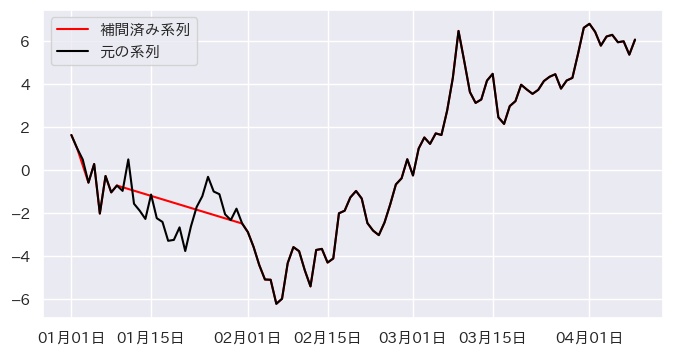

In [7]:
# 21時点連続で欠測
rw_missing.loc["2000-01-10":"2000-01-30"] = None

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(rw_missing.interpolate(), label="補間済み系列", color="red")
ax.plot(rw, label="元の系列", color="black")

# 凡例
ax.legend()

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m月%d日"))

In [8]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(DatetimeIndex)
date_index = pd.date_range(start="1949-01", periods=len(air_passengers), freq="MS")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [9]:
# データの2年間を欠測にする
air_passengers.loc["1955":"1956"] = None

In [10]:
# ローカルレベルモデル
mod_ll = tsa.UnobservedComponents(
    air_passengers, level="local level"  # 対象データ  # ローカルレベル
).fit()

# 季節変動ありのローカル線形トレンドモデル
mod_bsts = tsa.UnobservedComponents(
    air_passengers,  # 対象データ
    level="local linear trend",  # ローカル線形トレンド
    seasonal=12,  # 周期
).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85136D+00    |proj g|=  5.10240D-03

At iterate    5    f=  4.09645D+00    |proj g|=  8.10081D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     15      1     0     0   8.101D-06   4.096D+00
  F =   4.0964480013774169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


<Axes: >

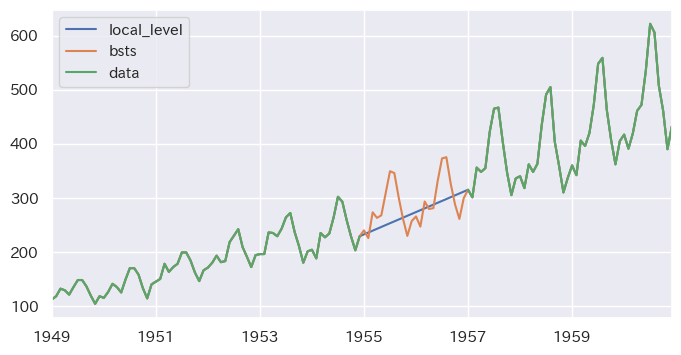

In [11]:
# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "local_level": mod_ll.level["smoothed"],
        "bsts": mod_bsts.level["smoothed"] + mod_bsts.seasonal["smoothed"],
        "data": air_passengers["value"],
    }
)

# 可視化
plot_df.plot()

In [12]:
# ------------------------------------------------------------
# 欠測日を含む時系列データの作成
# ------------------------------------------------------------
# 目的：
#   一部の日付を意図的に削除し、「日付が欠落した」不連続な時系列を生成する。
#   これは実務上、観測が行われなかった日（例：センサー停止、休日など）を
#   シミュレートするための処理である。
# ------------------------------------------------------------
# 手順：
#   1. 元のランダムウォーク系列 rw をコピーする。
#   2. pd.date_range() で 2000年1月4日から20日間の連続日付を作成。
#   3. drop() により、その期間のデータを削除する。
# ------------------------------------------------------------
# 欠測後の時系列は、インデックス（DatetimeIndex）が不連続になる。
# このような不連続時系列は、補間処理や季節調整の前処理段階で重要。
# ------------------------------------------------------------

rw_lack = rw.copy()  # 元データをコピー
rw_lack = rw_lack.drop(
    pd.date_range(start="2000-01-04", periods=20, freq="D")  # 欠測とする期間を指定
)

# 結果の確認（最初の数行）
print(rw_lack.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.484417
2000-01-24 -1.219103
2000-01-25 -0.318247


In [13]:
# ------------------------------------------------------------
# 日付の抜け漏れを欠測（NaN）として扱う処理
# ------------------------------------------------------------
# 目的：
#   drop() によって日付が不連続になった時系列に対し、
#   欠落した日付を「明示的な NaN（欠測値）」として補完する。
#
# 理論的背景：
#   pandas の `asfreq('D')` は「指定した頻度（ここでは日次）」に
#   時系列を再サンプリングする機能を持つ。
#   存在しない日付には NaN が自動的に挿入される。
#
#   これにより、インデックス（DatetimeIndex）が完全な連続系列となり、
#   以降の補間・平滑化・時系列モデリング（ARIMA, Kalman Filter 等）が
#   正常に行えるようになる。
#
#   なお、この処理は“観測の欠損”をデータ構造上で表現するものであり、
#   実際の欠測値推定（interpolation）とは異なる。
# ------------------------------------------------------------

# 欠測日を NaN として明示的に補う
rw_lack_full = rw_lack.asfreq("D")

# 結果の確認（最初の数行を表示）
print(rw_lack_full.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.484417
2000-01-04       NaN
2000-01-05       NaN


In [14]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

In [15]:
# ------------------------------------------------------------
# 線形回帰モデルによるAR(1)型の自己回帰予測
# ------------------------------------------------------------
# 目的：
#   「1時点前の値」から「次の時点の値」を予測する
#   単回帰（AR(1): 自己回帰次数1）のモデルを構築する。
#
# 理論的背景：
#   このモデルは次のように表される：
#     y_t = β₀ + β₁ y_{t-1} + ε_t
#
#   ・β₀: 切片（intercept）
#   ・β₁: 回帰係数（自己回帰係数）
#   ・ε_t: 誤差項（ホワイトノイズ）
#
#   sktime の make_reduction() を利用することで、
#   一般的な回帰モデル（ここでは LinearRegression）を
#   「時系列予測器」として再利用できる。
#   “strategy='recursive'” により、予測結果を次の入力に再帰的に使用する。
# ------------------------------------------------------------

# 予測器（基礎回帰モデルとして線形回帰を利用）
regressor_ar = LinearRegression()

# 1時点前の値を特徴量として再帰的に学習する予測器を生成
forecaster_ar = make_reduction(
    regressor_ar,
    window_length=1,  # 過去1時点の値を使用（AR(1)モデル相当）
    strategy="recursive",  # 予測値を次の入力に再帰的に利用
)

# モデルの学習（訓練データに対して当てはめ）
forecaster_ar.fit(train_air)

# 学習済みパラメータ（回帰係数・切片）を取得
params = forecaster_ar.get_fitted_params()

# 切片と係数を抽出
intercept = params["estimator__intercept"]
coef = params["estimator__coef"][0]

# 結果の確認
print("intercept:", intercept)
print("coef:     ", coef)

# ------------------------------------------------------------
# コメント：
#   ・coef ≈ 1 の場合、データは「単位根過程」に近く、非定常性が疑われる。
#   ・coef < 1 の場合、過去の値の影響が徐々に減衰する定常過程を意味する。
#   ・このような簡単な線形回帰AR(1)モデルは、Box-Jenkins法の基礎でもあり、
#     より高度なSARIMAや状態空間モデルの直感的理解に繋がる。
# ------------------------------------------------------------

intercept: 13.118081409372223
coef:      0.952049318694247


In [16]:
# 2時点目以降の予測
ar_pred = intercept + coef * air_passengers.shift(1).loc[test_air.index]

# 予測結果
print(ar_pred.head(3))

              value
1958-01  333.006652
1958-02  336.814850
1958-03  315.869765


In [17]:
# 予測精度
mae = mean_absolute_error(test_air, ar_pred)
mase = mean_absolute_scaled_error(test_air, ar_pred, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 42.54651676508815
MASE: 2.094055792945921


In [18]:
# 正しい長期予測の作り方
# 予測値を格納する入れ物
ar_pred_2 = pd.DataFrame({"value": np.zeros(len(test_air))}, index=test_air.index)

# 1時点目の予測は、訓練データの最後の時点の実測値を使う
ar_pred_2.loc["1958-01"] = intercept + coef * train_air.loc["1957-12"].iloc[0]

# 2時点目以降の予測は、1時点前の予測値を使う
for i in range(1, len(ar_pred_2)):
    ar_pred_2.iloc[i] = intercept + coef * ar_pred_2.iloc[i - 1]

# 予測結果
print(ar_pred_2.head(3))

              value
1958-01  333.006652
1958-02  330.156838
1958-03  327.443674


In [19]:
# sktimeによる予測結果と一致する
all(forecaster_ar.predict(fh=fh_air) == ar_pred_2)

True

In [20]:
# 予測精度
mae = mean_absolute_error(test_air, ar_pred_2)
mase = mean_absolute_scaled_error(test_air, ar_pred_2, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 127.04227618648179
MASE: 6.252770723069711


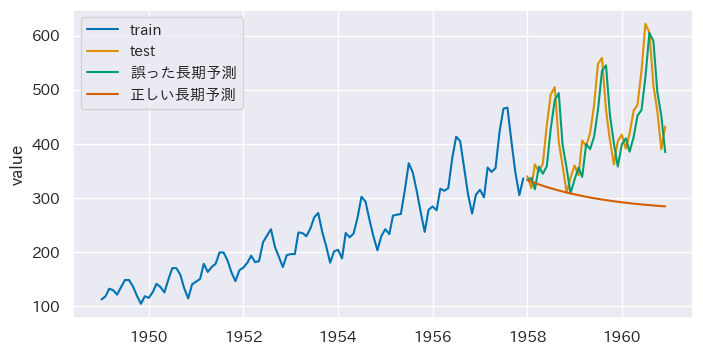

In [21]:
# 予測結果の可視化
fig, ax = plot_series(
    train_air,
    test_air,
    ar_pred,
    ar_pred_2,
    labels=["train", "test", "誤った長期予測", "正しい長期予測"],
    markers=np.tile("", 4),
)
fig.set_size_inches(8, 4)